In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Bayesian Statistics: Linear Regression

A linear regression problem is defined as:

y_i = w_i * x_i + E_i

Where:
* y_i is the vector of outcomes at step i
* w_i is the vector of weights (coefficients) at step i
* x_i is the vector of features (input data) at step i
* E_i is the error at step i

We must define a likelihood function, a prior distribution, and a posterior distribution to get our predictive distribution from which we can generate our linear regression.

Likelihood:
* Given the current model, how likely is the data pair y_i,x_i?
* p(y_i|x_i,w_i) = N(w_i * x_i.T,B^-1)
* w_i * x_i.T provides the vector mean estimate of y_i
* B^-1 is the sigma^2 or noise around that mean estimate
* This combination gives us a likelihood distribution of Normal/Gaussian shape.

Prior:
* For a Gaussian likelihood distribution, the appropriate prior is also a Gaussian:
    * p(w_0) = n(m_0,S_0)
* Our initial prior should look like:
    * m_0 = 0 in a n length vector
    * S_0 = alpha^-1 in a n by n covariance matrix
* This is simply the definition of a prior for a Gaussian likelihood distribution. Note that we could use a uniform distribution over some range near 0 as well as that could be considered an uninformed prior; however, we use a Gaussian because it makes an analytical solution simpler to calculate as our prior updates according to a Gaussian update step.

Posterior:
* The updated prior, given the new data pair y_i, x_i.
* p(w_i+1|w_i,x_i,y_i) = N(m_i+1,S_i+1) where:
    * S_i+1 = (S_i^-1 + B * x_i.T * x_i)^-1
    * m_i+1 = S_i+1 * (S_i^-1* m_i + B * x_i * y_i)

Predictive Distribution:
* p(y_i) = N(u_i,sigma_i) where
    * u_i = w_i * x_i.T
    * sigma_i = 1/B * x_i * S_i * x_i.T
* Thus, our line of best fit is u_i (our MAP) and we can expect some variance sigma_i around it, informed by the error of our line.


## Define the Bayesian Linear Regression class using the above definition

In [11]:
class BayesLinReg:
    """
    State
        self.n_features: the number of features 
        self.alpha: the shape parameter for the inverse gamma distribution
        self.beta: the scale parameter for the inverse gamma distribution
        self.mean: the coefficients currently estimating the line/
    """
    
    def __init__(self,n_features,alpha,beta):
        """
        Initialize the state variables
        """
        self.n_features = n_features
        self.alpha = alpha
        self.beta  = beta
        self.mean = np.zeros(n_features)
        self.cov_inv = np.identity(n_features) / alpha
    
    def fit_step(self,x,y):
        """
        Perform a single step in training the bayesian regression
        """
        
        # Update the inverse covariance matrix
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)

        # Update the mean vector using the new covariance matrix 
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)

        # Finish the update
        self.cov_inv = cov_inv
        self.mean = mean
        
        return self   
        
    def predict(self, x):
        """
        Using the current model, estimate the y of the given x.
        """
        
        # Obtain the predictive mean
        # Note that this predictive mean is not our draw.
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance
        
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        # We use the covariance (divided by two for standard deviation)
        # and mean to generate the distribution, then return the distribution
        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)
    
    @property
    def weights_dist(self):
        """
        Return the distribution of the weights
        """
        
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(mean=self.mean, cov=cov)

In [13]:
from sklearn import datasets
from sklearn import metrics
from scipy import stats

X, y = datasets.load_boston(return_X_y=True)

model = BayesLinReg(n_features=X.shape[1], alpha=1, beta=1)

y_pred = np.empty(len(y))

for i, (xi, yi) in enumerate(zip(X, y)):
    y_pred[i] = model.predict(xi).mean()
    model.fit_step(xi, yi)

print(metrics.mean_absolute_error(y, y_pred))

3.7888798406328736


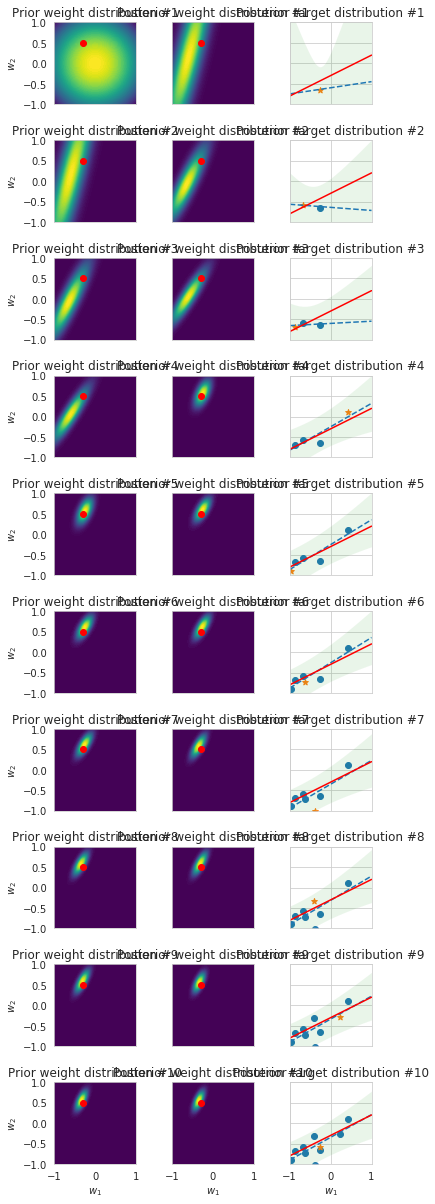

In [17]:
from mpl_toolkits.axes_grid1 import ImageGrid

np.random.seed(42)

# Pick some true parameters that the model has to find
weights = np.array([-.3, .5])

def sample(n):
    for _ in range(n):
        x = np.array([1, np.random.uniform(-1, 1)])
        y = np.dot(weights, x) + np.random.normal(0, .2)
        yield x, y

model = BayesLinReg(n_features=2, alpha=2, beta=25)

# The following 3 variables are just here for plotting purposes
N = 100
w = np.linspace(-1, 1, 100)
W = np.dstack(np.meshgrid(w, w))

n_samples = 10
fig = plt.figure(figsize=(7 * n_samples, 21))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(n_samples, 3),  # creates a n_samplesx3 grid of axes
    axes_pad=.5  # pad between axes in inch.
)

# We'll store the features and targets for plotting purposes
xs = []
ys = []

def prettify_ax(ax):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')
    return ax

for i, (xi, yi) in enumerate(sample(n_samples)):

    pred_dist = model.predict(xi)

    # Prior weight distribution
    ax = prettify_ax(grid[3 * i])
    ax.set_title(f'Prior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')  # true weights the model has to find

    # Update model
    model.fit_step(xi, yi)

    # Prior weight distribution
    ax = prettify_ax(grid[3 * i + 1])
    ax.set_title(f'Posterior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')  # true weights the model has to find

    # Posterior target distribution
    xs.append(xi)
    ys.append(yi)
    posteriors = [model.predict(np.array([1, wi])) for wi in w]
    ax = prettify_ax(grid[3 * i + 2])
    ax.set_title(f'Posterior target distribution #{i + 1}')
    # Plot the old points and the new points
    ax.scatter([xi[1] for xi in xs[:-1]], ys[:-1])
    ax.scatter(xs[-1][1], ys[-1], marker='*')
    # Plot the predictive mean along with the predictive interval
    ax.plot(w, [p.mean() for p in posteriors], linestyle='--')
    cis = [p.interval(.95) for p in posteriors]
    ax.fill_between(
        x=w,
        y1=[ci[0] for ci in cis],
        y2=[ci[1] for ci in cis],
        alpha=.1
    )
    # Plot the true target distribution
    ax.plot(w, [np.dot(weights, [1, xi]) for xi in w], color='red')